In [2]:
suppressWarnings(suppressMessages(library(tidyverse))) #ggplot and dplyr
suppressWarnings(suppressMessages(library(reshape2))) #melt
suppressWarnings(suppressMessages(library(VIM)))

# EAD - Assignment2
## Health systems -> How do each country's health indicators influence the growth of covid cases, tests and deaths?

Vasco Campos -> up201908482

Bruno Reis -> up201908682

__Estatística e Análise de dados__, June 2020

# Introduction
blah blah blah

# Datasets: adding predictor and target variables
The main dataset contains some health system indicators for each country in the world, but lacks target variables and some descriptive variables like the population of the country for example or its continent.

## World bank health systems
__What does each column mean?__
1. __Country__: the region as used in Kaggle Covid-19 spread data challenges.
2. __Province__: the region as used in Kaggle Covid-19 spread data challenges.
3. __Bank_Name__: the name of the country used by the World Bank
4. __Health_exp_pct_of_GDP__: Level of current health expenditure expressed as a percentage of GDP. Estimates of current health expenditures include healthcare goods and services consumed during each year. This indicator does not include capital health expenditures such as buildings, machinery, IT and stocks of vaccines for emergency or outbreaks.
5. __Health_exp_funded_by_public__: Share of current health expenditures funded from domestic public sources for health. Domestic public sources include domestic revenue as internal transfers and grants, transfers, subsidies to voluntary health insurance beneficiaries, non-profit institutions serving households (NPISH) or enterprise financing schemes as well as compulsory prepayment and social health insurance contributions. They do not include external resources spent by governments on health.
6. __Health_exp_funded_by_household__: Share of out-of-pocket payments of total current health expenditures. Out-of-pocket payments are spending on health directly out-of-pocket by households.
7. __Health_exp_percapita_USD__: Current expenditures on health per capita in current US dollars. Estimates of current health expenditures include healthcare goods and services consumed during each year.
8. __Health_exp_percapita_PPP__: Current expenditures on health per capita expressed in international dollars at purchasing power parity (PPP).
9. __Health_exp_pct_funded_by_externals__: Share of current health expenditures funded from external sources. External sources compose of direct foreign transfers and foreign transfers distributed by government encompassing all financial inflows into the national health system from outside the country. External sources either flow through the government scheme or are channeled through non-governmental organizations or other schemes.
10. __Physicians_per_1000__: Physicians include generalist and specialist medical practitioners.
11. __Nurses_per_1000__: Nurses and midwives include professional nurses, professional midwives, auxiliary nurses, auxiliary midwives, enrolled nurses, enrolled midwives and other associated personnel, such as dental nurses and primary care nurses.
12. __Specialist_surgical_per_100000__: Specialist surgical workforce is the number of specialist surgical, anaesthetic, and obstetric (SAO) providers who are working in each country per 100,000 population.
13. __Birth_reg_pct__: Completeness of birth registration is the percentage of children under age 5 whose births were registered at the time of the survey. The numerator of completeness of birth registration includes children whose birth certificate was seen by the interviewer or whose mother or caretaker says the birth has been registered.
14. __Death_reg_pct__: Completeness of death registration is the estimated percentage of deaths that are registered with their cause of death information in the vital registration system of a country.

In [66]:
df = read_csv("2.12_Health_systems.csv", col_types = c("cccddddddddddd"))
colnames(df) = c("Country", "Province", "Bank_Name", "Health_exp_pct_of_GDP", "Health_exp_funded_by_public", "Health_exp_funded_by_household", "Health_exp_percapita_USD", 
                "Health_exp_percapita_PPP", "Health_exp_pct_funded_by_externals", "Physicians_per_1000", "Nurses_per_1000", "Specialist_surgical_per_100000", "Birth_reg_pct", "Death_reg_pct")
head(df)

Country,Province,Bank_Name,Health_exp_pct_of_GDP,Health_exp_funded_by_public,Health_exp_funded_by_household,Health_exp_percapita_USD,Health_exp_percapita_PPP,Health_exp_pct_funded_by_externals,Physicians_per_1000,Nurses_per_1000,Specialist_surgical_per_100000,Birth_reg_pct,Death_reg_pct
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,NA,Afghanistan,10.2,5.1,77.4,57.2,162.8,17.5,0.3,0.3,0.0,42.3,NaN
Albania,NA,Albania,6.7,41.4,58.0,271.5,759.7,0.7,1.2,3.6,11.6,98.4,53
Algeria,NA,Algeria,6.6,67.7,30.9,260.4,998.2,0.0,1.8,2.2,12.1,100.0,NaN
Andorra,NA,Andorra,10.4,49.1,41.7,3834.7,4978.7,NaN,3.3,4.0,83.1,100.0,80
Angola,NA,Angola,2.9,44.1,35.2,95.2,185.8,3.6,0.2,1.3,NaN,25.0,NaN
Antigua and Barbuda,NA,Antigua and Barbuda,4.3,60.6,32.2,623.1,976.4,0.0,2.8,3.1,14.0,NaN,79


# PreProcessing
## Removing NANs
First, we check how many nans are in each column of the dataset.

Province has a lot of NA values, because it only contains the provinces of countries and is NA when the country has no province.

In [67]:
cat("percentage of missing values in the entire dataset:", mean(is.na(df) * 100), "%\n")
print(colMeans(is.na(df)))

percentage of missing values in the entire dataset: 20.71429 %
                           Country                           Province 
                         0.1095238                          0.9333333 
                         Bank_Name              Health_exp_pct_of_GDP 
                         0.0000000                          0.1142857 
       Health_exp_funded_by_public     Health_exp_funded_by_household 
                         0.1142857                          0.1142857 
          Health_exp_percapita_USD           Health_exp_percapita_PPP 
                         0.1142857                          0.1142857 
Health_exp_pct_funded_by_externals                Physicians_per_1000 
                         0.2047619                          0.1000000 
                   Nurses_per_1000     Specialist_surgical_per_100000 
                         0.1000000                          0.1666667 
                     Birth_reg_pct                      Death_reg_pct 
              

We decide to remove the variables _Country_ and _Province_, because of the NAs and because the Country variable is only an id for each observation, therefore it has no real information to give us.

The _Death_reg_pct_ is removed due to a high number of NAs and because it would not be viable to impute such a large number of values.

In [68]:
df = df[, !names(df) %in% c("Country", "Province", "Death_reg_pct")]

__Removing all observations that have three or more null values__

This way, most null values are eliminated in an efficient way that also removes the observations with less information available.

In [70]:
df$na_count <- apply(is.na(df), 1, sum)
df = df[(df[,"na_count"]<=3),]

In [71]:
cat("Percentage of missing values in dataset after removing observation with 3 or more NA values:", mean(is.na(df)) * 100, "%")

Percentage of missing values in dataset after removing observation with 3 or more NA values: 3.181004 %

### KNN imputation
The remaining __3.18%__ of missing values in the dataset are dealt with using the KNN imputation technique. This way, we are able to impute values into observations based on the median of their 5 nearest neighbors.

In [72]:
imputed_data = kNN(df[, 2:11], imp_var = FALSE, useImputedDist = FALSE)
imputed_data$Bank_Name = df$Bank_Name
cat("Percentage of missing values after KNN imputation:", mean(is.na(imputed_data)), "%")

Percentage of missing values after KNN imputation: 0 %

As we can see, the final percentage of missing values is __0%__, meaning our data is ready to be explored.

# Univariate analysis

In [73]:
summary(imputed_data$Health_exp_pct_of_GDP)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.700   4.500   6.200   6.715   8.375  23.300 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



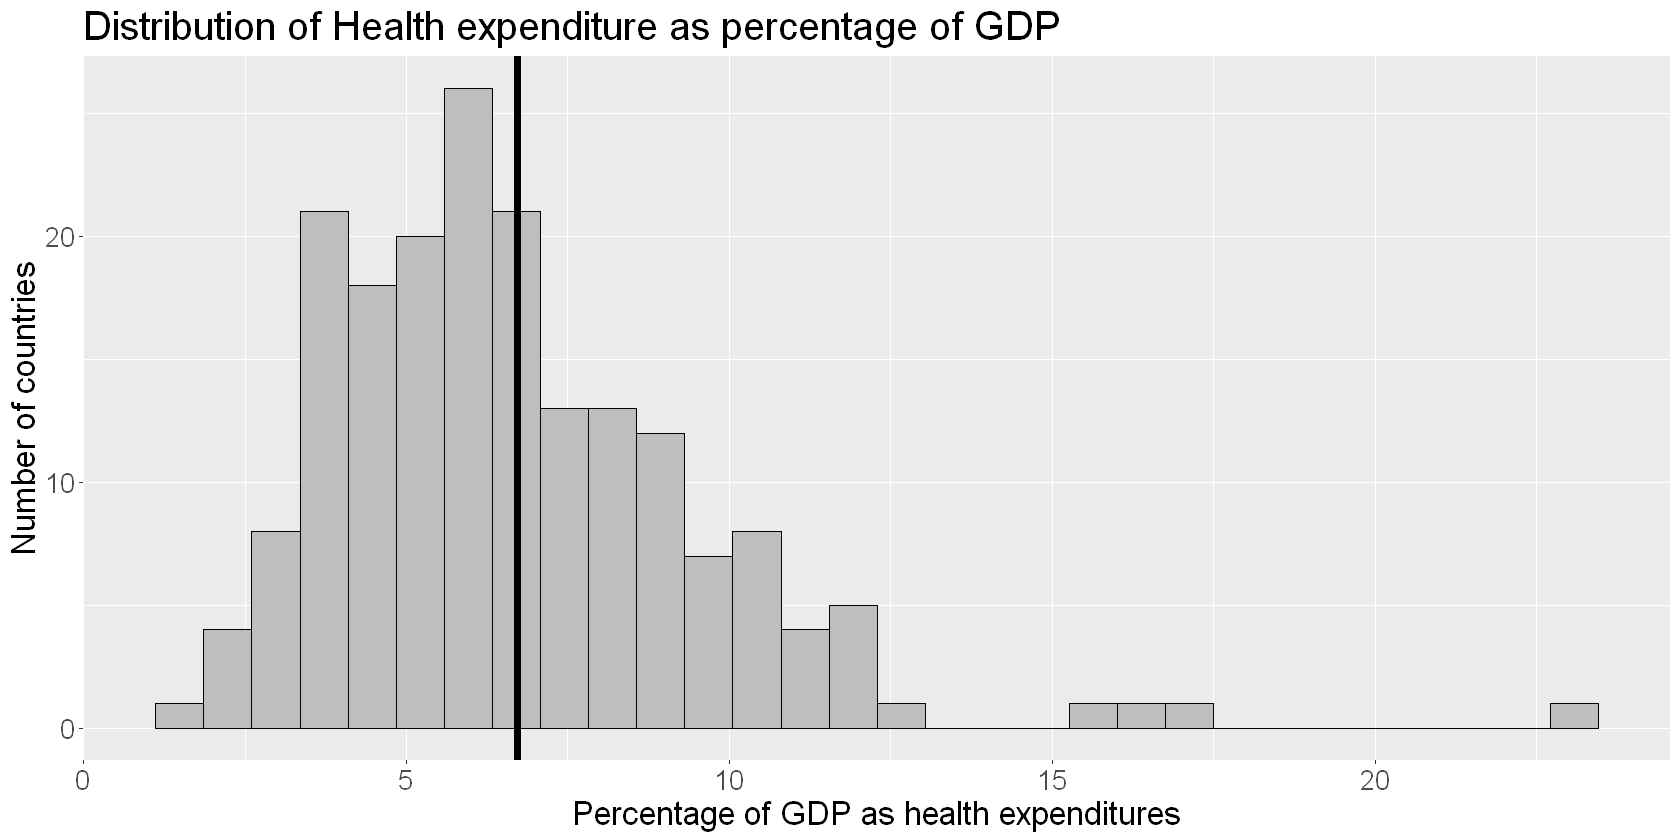

In [74]:
options(repr.plot.width = 14, repr.plot.height = 7)

imputed_data %>% ggplot(aes(Health_exp_pct_of_GDP)) +
    geom_histogram(color = "black", fill = "grey") +
    geom_vline(xintercept = mean(df$Health_exp_pct_of_GDP), lwd = 2) + 
    labs(title = "Distribution of Health expenditure as percentage of GDP", x = "Percentage of GDP as health expenditures", y = "Number of countries") +
    theme(text = element_text(size = 20))